# Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.004 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 32.367 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.027 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 32.395 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 69.555 MiB RAM in 0.447s, peaked 2.562 MiB above current, total RAM usage 101.949 MiB


In [4]:
lens = pd.merge(movies, ratings)

In [4] used 54.469 MiB RAM in 0.133s, peaked 0.000 MiB above current, total RAM usage 156.418 MiB


In [5]:
size_pandas = mw.measurements.memory_delta
size_pandas

54.46875

In [5] used 0.047 MiB RAM in 0.010s, peaked 0.000 MiB above current, total RAM usage 156.465 MiB


In [6]:
# pandas also comes with its own tool for getting memory usage
print(lens.memory_usage())

Index             8001672
movie_id          8001672
title             8001672
genres            8001672
user_id           8001672
rating            8001672
unix_timestamp    8001672
dtype: int64
In [6] used 0.152 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 156.617 MiB


### Exercise

Why do you think that the size is the same for every column in the dataframe?

*Hint:* Pandas stores the string columns in NumPy containers with 'object' dtype.

In [7]:
# See how pandas dataframe looks like
print(lens[:10])
lens.info()

   movie_id             title                       genres  user_id  rating  \
0         1  Toy Story (1995)  Animation|Children's|Comedy        1       5   
1         1  Toy Story (1995)  Animation|Children's|Comedy        6       4   
2         1  Toy Story (1995)  Animation|Children's|Comedy        8       4   
3         1  Toy Story (1995)  Animation|Children's|Comedy        9       5   
4         1  Toy Story (1995)  Animation|Children's|Comedy       10       5   
5         1  Toy Story (1995)  Animation|Children's|Comedy       18       4   
6         1  Toy Story (1995)  Animation|Children's|Comedy       19       5   
7         1  Toy Story (1995)  Animation|Children's|Comedy       21       3   
8         1  Toy Story (1995)  Animation|Children's|Comedy       23       4   
9         1  Toy Story (1995)  Animation|Children's|Comedy       26       3   

   unix_timestamp  
0       978824268  
1       978237008  
2       978233496  
3       978225952  
4       978226474  
5       97

### Solution

In [8]:
# Use deep=True for including the size of the object types
print(lens.memory_usage(deep=True))

Index              8001672
movie_id           8001672
title             68344698
genres            59662643
user_id            8001672
rating             8001672
unix_timestamp     8001672
dtype: int64
In [8] used 0.047 MiB RAM in 0.085s, peaked 0.000 MiB above current, total RAM usage 181.469 MiB


In [9]:
# For a more realistic memory usage, we are going to use deep=True
size_pandas2 = lens.memory_usage(deep=True).sum() / 2**20.
size_pandas2

160.23225879669189

In [9] used 0.012 MiB RAM in 0.093s, peaked 0.000 MiB above current, total RAM usage 181.480 MiB


In [10]:
# Let's see how fast a query can be
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

10 loops, best of 3: 30 ms per loop


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [10] used 0.191 MiB RAM in 1.287s, peaked 0.000 MiB above current, total RAM usage 181.672 MiB


In [11]:
# Sotre it for future reference
qtime_pandas = t.best

In [11] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 181.680 MiB


## Use a compressed in-memory container via `bcolz`

In [12]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 9
bcolz.defaults.cparams['shuffle'] = bcolz.BITSHUFFLE  # try with NOSHUFFLE and BITSHUFFLE as well
bcolz.set_nthreads(1)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.0.1.dev99
bcolz git info:    1.0.0-99-gcbe1434
NumPy version:     1.11.0
Blosc version:     1.9.1 ($Date:: 2016-05-20 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.6.1.dev0
Dask version:      0.9.0
Python version:    2.7.11 |Continuum Analytics, Inc.| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


8

In [12] used 7.031 MiB RAM in 0.043s, peaked 0.000 MiB above current, total RAM usage 188.711 MiB


In [13]:
zlens = bcolz.ctable.fromdataframe(lens)

In [13] used 0.340 MiB RAM in 0.195s, peaked 78.199 MiB above current, total RAM usage 189.051 MiB


In [14]:
size_bcolz = mw.measurements.memory_delta
size_bcolz

0.33984375

In [14] used 0.012 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 189.062 MiB


Sometimes the memory reported as used is too much biased (don't know exactly why), so let's repeat the operation, but using a different container:

In [15]:
zlens2 = bcolz.ctable.fromdataframe(lens)

In [15] used 0.062 MiB RAM in 0.190s, peaked 78.031 MiB above current, total RAM usage 189.125 MiB


In [16]:
size_bcolz2 = zlens2.cbytes / 2**20.
size_bcolz2

7.253473281860352

In [16] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 189.125 MiB


In [17]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.25 MB; ratio: 21.17
  cparams := cparams(clevel=9, shuffle=2, cname='lz4', quantize=0)
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [17] used 0.012 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 189.137 MiB


In [18]:
size_pandas2 / size_bcolz2

22.090418282425375

In [18] used 0.004 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 189.141 MiB


We can see that the space taken by a bcolz container is around 20x smaller (!) than a pandas one.

In [19]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

10 loops, best of 3: 26.6 ms per loop
In [19] used 8.320 MiB RAM in 1.137s, peaked 0.000 MiB above current, total RAM usage 197.461 MiB


In [20]:
qtime_bcolz = t.best

In [20] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 197.461 MiB


In [21]:
qtime_pandas / qtime_bcolz

1.127981118275517

In [21] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 197.461 MiB


We see that by using a compressed bcolz container, it provides similar query times than pandas.

In [22]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

('results with pandas Dataframe:', 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64)
('results with bcolz ctable:', [(5121, 75), (5164, 3842), (5187, 6031)])
In [22] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 197.461 MiB


## Use a *uncompressed* in-memory container via `bcolz`

So, what happens when we use an uncompressed container in bcolz?  We do expect better speed?  If so, how much?  Let's measure:

In [23]:
bcolz.defaults.cparams['clevel'] = 0

In [23] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 197.461 MiB


In [24]:
uzlens = bcolz.ctable.fromdataframe(lens)
uzlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 154.50 MB; ratio: 0.99
  cparams := cparams(clevel=0, shuffle=2, cname='lz4', quantize=0)
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [24] used 263.340 MiB RAM in 0.229s, peaked 0.000 MiB above current, total RAM usage 460.801 MiB


In [25]:
size_ubcolz = mw.measurements.memory_delta
size_ubcolz

263.33984375

In [25] used 0.000 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 460.801 MiB


In [26]:
size_ubcolz2 = uzlens.cbytes / 2**20.
size_ubcolz2

154.49602890014648

In [26] used 0.000 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 460.801 MiB


In [27]:
size_pandas2 / size_ubcolz2

1.0371286559103265

In [27] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 460.801 MiB


We can see that the space taken by an uncompressed bcolz container is very close to a pandas one (but keep an eye on the reported memory usage by memory_watcher).

In [28]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in uzlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in uzlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

100 loops, best of 3: 19.2 ms per loop
In [28] used 0.543 MiB RAM in 7.924s, peaked 0.000 MiB above current, total RAM usage 461.344 MiB


In [29]:
qtime_ubcolz = t.best

In [29] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 461.352 MiB


In [30]:
qtime_pandas / qtime_ubcolz

1.5619854388755132

In [30] used 0.000 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 461.352 MiB


## Using structured NumPy arrays

In [31]:
nalens = lens.to_records()

In [31] used 0.000 MiB RAM in 0.412s, peaked 0.000 MiB above current, total RAM usage 461.352 MiB


In [32]:
size_numpy = mw.measurements.memory_delta
size_numpy

0.0

In [32] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 461.352 MiB


In [33]:
nalens

rec.array([ (0, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268),
 (1, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008),
 (2, 1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496),
 ...,
 (1000206, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656),
 (1000207, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537),
 (1000208, 3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)], 
          dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', 'O'), ('genres', 'O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [33] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 461.352 MiB


In [34]:
size_numpy2 = round((nalens.size * nalens.dtype.itemsize) / 2**20., 3)
size_numpy2

53.417

In [34] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 461.352 MiB


In [35]:
# But, again, this does not account for 'O'bject dtypes, which are stored in its own storage area
# So, let's take this into account
import sys
size_numpy3 = size_numpy2 + round(sum(sum(sys.getsizeof(o) for o in nalens[col]) for col in ('title', 'genres')) // 2**20., 3)
size_numpy3

159.417

In [35] used 0.000 MiB RAM in 0.519s, peaked 0.000 MiB above current, total RAM usage 461.352 MiB


In [36]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

100 loops, best of 3: 13.8 ms per loop


rec.array([ (5121, 8, 'Tom and Huck (1995)', "Adventure|Children's", 75, 5, 977851520),
 (5164, 8, 'Tom and Huck (1995)', "Adventure|Children's", 3842, 5, 967986151),
 (5187, 8, 'Tom and Huck (1995)', "Adventure|Children's", 6031, 5, 956718223)], 
          dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', 'O'), ('genres', 'O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [36] used 0.004 MiB RAM in 5.709s, peaked 0.000 MiB above current, total RAM usage 461.355 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas (a hair less actually).

In [37]:
qtime_numpy = t.best

In [37] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 461.355 MiB


## Performance comparsion

In [38]:
%matplotlib inline

In [38] used 6.188 MiB RAM in 0.068s, peaked 0.000 MiB above current, total RAM usage 467.543 MiB


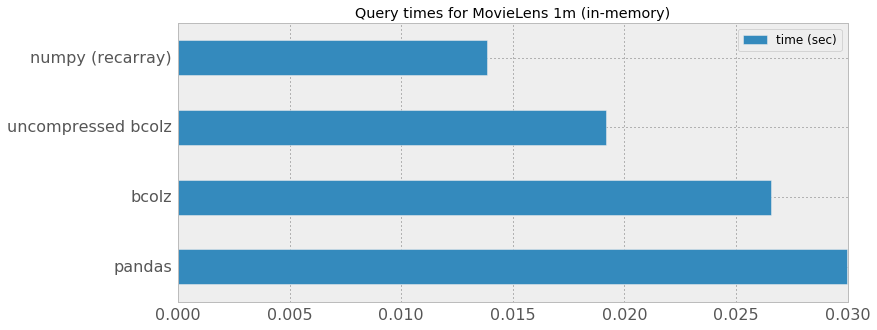

In [41] used 0.832 MiB RAM in 0.204s, peaked 0.000 MiB above current, total RAM usage 475.625 MiB


In [41]:
# Query times
labels = ["pandas", "bcolz", "uncompressed bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_ubcolz, qtime_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

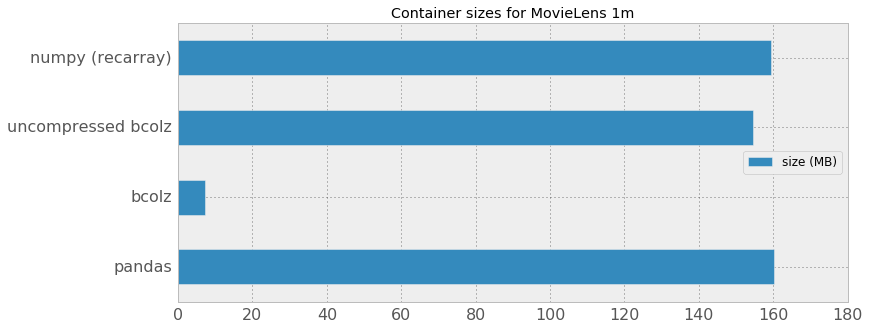

In [42] used 0.914 MiB RAM in 0.213s, peaked 0.000 MiB above current, total RAM usage 476.539 MiB


In [42]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas2, size_bcolz2, size_ubcolz2, size_numpy3]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)